In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 100)

#显示所有行

pd.set_option('display.max_rows', 100)

import warnings
warnings.filterwarnings("ignore")
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import numpy as np

import sys
import time
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import datetime
import warnings
import feather
warnings.filterwarnings("ignore")
import math
sys.path.append('/data/apps/modules/jupyter')
from helper.spark_helper import *
from helper.presto_helper import query_presto
from helper.csv_helper import *
from helper.pandas_helper import *
from helper.presto_helper import query_hive_wy

# 用户单量统计-偏好划分

In [3]:
def get_user_detail_df(city_id,start_date,end_date):

    d_df=get_df_from_csv_table(query_presto(f'''
        select user_id,bike_sn,order_id,city_id,event_day
        from dwd.dwd_bd_order_detail_da
        where city_id={city_id} and event_day between '{start_date}' and '{end_date}'
    '''))
    
    return d_df


city_id=196
start_date='20210207'
end_date='20210407'

#用户60天内单量统计
user_detail_df=get_user_detail_df(city_id,start_date,end_date)
user_statistics_df=user_detail_df.groupby('user_id').bike_sn.count().reset_index()

# 用户基础特征获取-性别、年龄、手机品牌、操作系统

In [5]:
def get_user_picture_df(city_id_str,event_day):
    user_picture = get_df_from_csv_table(query_presto(f'''
        select a.user_id, a.city_id, a.gender,a.mobile,a.first_order_time,a.birthday, b.model, b.brand, b.sys_ver
        from
        (select user_id, city_id,birthday, gender, mobile,first_order_time
        from dim.dim_user_info_df
        where city_id in ({city_id_str})
        and gender!=0
        and birthday is not null
        and event_day='{event_day}') a left join
        (select user_id, model, brand, sys_ver
        from dws.dws_pt_user_action_da
        where event_day='{event_day}') b on a.user_id=b.user_id
    '''))

    return user_picture

city_id_str=str(city_id)
event_day='20210407'
user_picture_df=get_user_picture_df(city_id_str,event_day)

In [7]:
def get_register_span(x):
    """
    用户注册时间跨度
    """
    time_list=x['first_order_time'][:10].split('-')
    time_span=datetime.date(2021,4,7)-\
                datetime.date(int(time_list[0]),int(time_list[1]),int(time_list[2]))
    time_span=time_span.days+1
    return time_span

user_picture_df['age'] = user_picture_df['birthday'].map(lambda x: int(time.strftime("%Y",time.localtime(time.time())))-int(x[:4])+1)
user_picture_df['register_span']=user_picture_df.apply(get_register_span,axis=1)

In [8]:
print(user_statistics_df.shape,user_picture_df.shape)

(40894, 2) (104872, 11)


In [14]:
def split_window_func(x):
    """
    用户单量分段    
    """

    if x['order_day_avg']>1:
        return 1
    elif  0.5<x['order_day_avg']<=1:
        return 2
    elif  0.4<x['order_day_avg']<=0.5:
        return 3
    elif  0.3<x['order_day_avg']<=0.4:
        return 4
    elif  0.2<x['order_day_avg']<=0.3:
        return 5
    elif  0.1<x['order_day_avg']<=0.2:
        return 6
    elif  0<x['order_day_avg']<=0.1:
        return 7
    else:
        return 8

merge_df=user_picture_df.merge(user_statistics_df,on='user_id',how='left')
merge_df['order_day_avg']=merge_df.apply(lambda x:x['bike_sn']/60 if x['register_span']>59 else x['bike_sn']/x['register_span'],axis=1)
merge_df['window']=merge_df.apply(split_window_func,axis=1)

<AxesSubplot:>

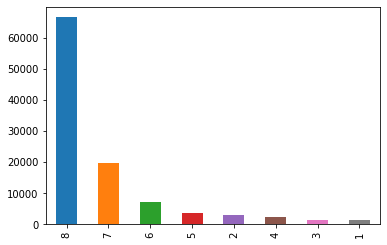

In [15]:
merge_df['window'].value_counts().plot.bar()

In [16]:
def get_age_transform(x):
    if x<20:
        return 1
    elif 20<=x<=24:
        return 2
    elif 25<=x<=29:
        return 3
    elif 30<=x<=34:
        return 4
    elif 35<=x<=39:
        return 5
    elif 40<=x<=44:
        return 6
    else:
        return 7
def get_brand_transform(x):
    if x=='HUAWEI':
        return 1
    elif x=='OPPO':
        return 2
    elif x=='vivo':
        return 3
    elif x=='iPhone' or x=='Apple':
        return 4
    elif x=='HONOR':
        return 5
    else:
        return 6

merge_df['age_transformed']=merge_df.age.apply(get_age_transform)    
merge_df['brand_transformed']=merge_df.brand.apply(get_brand_transform)

In [42]:
import re
def edit_ver(x):
    try:
        if type(x)==type(0.1) or type(x)==type(1):
            return 'None'
        elif re.match('\d+\..*', x):
            return 'Android '+re.search('\d+', x)[0]
        elif re.match('Android \d+\..*', x):
            return 'Android '+re.search('\d+', x)[0]
        elif re.match('Android \d+$', x):
            return x
        elif re.match('iOS \d+$', x):
            return x
        elif re.match('iOS\d+\..*', x):
            return 'iOS '+re.search('\d+',x)[0]
        elif re.match('iOS \d+\..*', x):
            return 'iOS '+re.search('\d+',x)[0]
        elif re.match('\d+$', x):
            return 'Android '+x
        else:
            return 'Other'
    except:
        print(type(x))
def get_sys_ver_transform(x):
    if x[:3]=='iOS':
        if x.split(' ')[-1]=='14':
            return 1
        elif x.split(' ')[-1]=='13':
            return 2
        else:
            return 7
    elif x.split(' ')[-1]=='10':
        return 3
    elif x.split(' ')[-1]=='11':
        return 4
    elif x.split(' ')[-1]=='9':
        return 5
    elif x.split(' ')[-1]=='8':
        return 6
    else:
        return 7
merge_df2=merge_df
merge_df2=merge_df2.fillna(0)
merge_df2['sys_ver_transform1']=merge_df2.sys_ver.apply(edit_ver)         

In [43]:
def get_sys_ver_transform(x):
    try:
        if x.split(' ')[-1]=='11':
            return 1
        elif x.split(' ')[-1]=='10':
            return 2
        elif x.split(' ')[-1]=='9':
            return 3
        elif x.split(' ')[-1]=='8':
            return 4
        else:
            return 5
    except:
        print(x)
        
        
merge_df2['sys_ver_transformed']=merge_df2.sys_ver_transform1.apply(get_sys_ver_transform) 

In [ ]:
'sys_ver_transformed','brand_transformed','age_transformed','gender'

# 极光特征

In [54]:
def edit_query_result(x):
    if x=='查询标签成功-有标签':
        return 1
    else:
        return 0
    
jiguang_df=pd.read_csv('iaudience.csv').rename({'imei/phone/mac/imsi':'mobile'},axis=1)
jiguang_df['query_result']=jiguang_df.查询结果.map(edit_query_result)
jiguang_df=jiguang_df[jiguang_df.query_result==1]

merge_df2['mobile']=merge_df2['mobile'].astype('int')
jg_sg_df=pd.merge(jiguang_df,merge_df2,on='mobile',how='left')

In [56]:
jg_sg_df=jg_sg_df.fillna('None')

In [57]:
transform_list=['CPL_INDM_EDU_LEVEL',
              'CPL_INDM_MARRC2',
              'FIM_FISM_INCL',
              'FIM_FISM_CONL_CIR']
from sklearn import preprocessing
lbl = preprocessing.LabelEncoder()
lis=[]
for col in transform_list:
    try:
        jg_sg_df[col+'_transformed'] = lbl.fit_transform(jg_sg_df[col].astype('category'))
    except:
        lis.append(col)

In [59]:
def get_SOM_OCM_CAREER_transform(x):
    if x=='企业人员':
        return 1
    elif x=='白领':
        return 2
    elif x=='公务人员':
        return 3
    else:
        return 4
jg_sg_df['SOM_OCM_CAREER_transformed']=jg_sg_df.SOM_OCM_CAREER.apply(get_SOM_OCM_CAREER_transform)

In [60]:
import re
def edit_app_hoby(x):

    if x=="None":
        return 0
    else:
        return float(re.findall(r'\d+\.\d+',x)[0])

hobby_list=[
'APP_HOBY_SHORT_VIDEO',
'APP_HOBY_SUMMARY_VIDEO' ,
'APP_HOBY_SELF_PHOTO' ,
'APP_HOBY_SUNMMARY_NEWS' ,
'APP_HOBY_SPEED_GAME',
'APP_HOBY_WIFI',
'APP_HOBY_FOOD',
'APP_HOBY_RECORD',
'APP_HOBY_HOT_SOCIAL' ,
'APP_HOBY_ONLINE_STUDY' ,
'APP_HOBY_ZONGHE_SHOPPING' ,
'APP_HOBY_DISCOUNT_MARKET' ,
'APP_HOBY_GROUP_BUY' ,
'APP_HOBY_SMOTE_OFFICE'
                 ]

jg_sg_df['APP_HOBY_SHORT_VIDEO']=jg_sg_df.APP_HOBY_SHORT_VIDEO.map(edit_app_hoby)
jg_sg_df['APP_HOBY_ZONGHE_SHOPPING']=jg_sg_df.APP_HOBY_ZONGHE_SHOPPING.map(edit_app_hoby)
jg_sg_df['APP_HOBY_DISCOUNT_MARKET']=jg_sg_df.APP_HOBY_DISCOUNT_MARKET.map(edit_app_hoby)
jg_sg_df['APP_HOBY_GROUP_BUY']=jg_sg_df.APP_HOBY_GROUP_BUY.map(edit_app_hoby)
jg_sg_df['APP_HOBY_SUMMARY_VIDEO']=jg_sg_df.APP_HOBY_SUMMARY_VIDEO.map(edit_app_hoby)
jg_sg_df['APP_HOBY_SELF_PHOTO']=jg_sg_df.APP_HOBY_SELF_PHOTO.map(edit_app_hoby)
jg_sg_df['APP_HOBY_SUNMMARY_NEWS']=jg_sg_df.APP_HOBY_SUNMMARY_NEWS.map(edit_app_hoby)
jg_sg_df['APP_HOBY_SPEED_GAME']=jg_sg_df.APP_HOBY_SPEED_GAME.map(edit_app_hoby)
jg_sg_df['APP_HOBY_WIFI']=jg_sg_df.APP_HOBY_WIFI.map(edit_app_hoby)
jg_sg_df['APP_HOBY_FOOD']=jg_sg_df.APP_HOBY_FOOD.map(edit_app_hoby)
jg_sg_df['APP_HOBY_RECORD']=jg_sg_df.APP_HOBY_RECORD.map(edit_app_hoby)
jg_sg_df['APP_HOBY_HOT_SOCIAL']=jg_sg_df.APP_HOBY_HOT_SOCIAL.map(edit_app_hoby)
jg_sg_df['APP_HOBY_ONLINE_STUDY']=jg_sg_df.APP_HOBY_ONLINE_STUDY.map(edit_app_hoby)
jg_sg_df['APP_HOBY_SMOTE_OFFICE']=jg_sg_df.APP_HOBY_SMOTE_OFFICE.map(edit_app_hoby)

# 极光复合特征拆分 GBM_BHM_PURB_CONP

In [63]:
jg_sg_df2=jg_sg_df

catagories_set = set()
for row in jg_sg_df2['GBM_BHM_PURB_CONP']:
    catagories_set |= set(row.split('、'))
catagories_set.discard("")    
catagories_set.discard("None")
catagories = list(catagories_set)
catagories_df = pd.DataFrame(columns=catagories)

jg_sg_df2=jg_sg_df2.join(catagories_df,how='outer')

for col in catagories:
    jg_sg_df2[col] = jg_sg_df2['GBM_BHM_PURB_CONP'].apply(lambda x: 1 if col in x.split('、') else 0)

In [67]:
jg_sg_df2=jg_sg_df2.rename({'品牌折扣':'big_offs'},axis=1)

In [81]:
#删除‘None’
jg_sg_df3=jg_sg_df2[jg_sg_df2.sys_ver_transformed!='None']

jg_sg_df3['sys_ver_transformed']=jg_sg_df3['sys_ver_transformed'].astype('int')
jg_sg_df3['age_transformed']=jg_sg_df3['age_transformed'].astype('int')
jg_sg_df3['brand_transformed']=jg_sg_df3['brand_transformed'].astype('int')
jg_sg_df3['gender']=jg_sg_df3['gender'].astype('int')

# 模型最终数据准备

In [82]:
jg_sg_df3.window.value_counts()

8.0    9851
7.0    7745
6.0    2714
5.0    1392
2.0    1091
4.0     846
3.0     509
1.0     462
Name: window, dtype: int64

In [196]:
jg_sg_df3['pref']=jg_sg_df3.window.map(lambda x:1 if x<=6 else 0)

In [197]:
jg_sg_df3['pref'].value_counts()

0    17596
1     7014
Name: pref, dtype: int64

In [558]:
def get_pref(x):
    if x<=2: 
        return 1
    elif x==8: 
        return 0 
    else:
        return -1
    
jg_sg_df3['pref1']=jg_sg_df3.window.apply(get_pref)

#正负样本比例
a=jg_sg_df3[jg_sg_df3.pref1 !=-1]['pref1'].sum()*100.0/jg_sg_df3[jg_sg_df3.pref1 !=-1]['pref1'].count()
print('train_df (1,0): ({},{})'.format(round(a,2),round(100-a,2)))

jg_sg_df3['pref1'].value_counts()

train_df (1,0): (13.62,86.38)


-1    13206
 0     9851
 1     1553
Name: pref1, dtype: int64

In [485]:
def down_sample(df):
    df1=df[df['pref1']==1]#正例
    df2=df[df['pref1']==0]#负例
    df3=df2.sample(frac=0.25)#抽负例
    return pd.concat([df1,df3],ignore_index=True)

def up_sample(df):
    df1=df[df['pref1']==1]#正例
    df2=df[df['pref1']==0]#负例
    df3=pd.concat([df1,df1,df1,df1,df1],ignore_index=True)
    return pd.concat([df2,df3],ignore_index=True)

up_train_df=up_sample(jg_sg_df3)
down_train_df=down_sample(jg_sg_df3)

In [486]:
print(down_train_df['pref1'].value_counts())
print(up_train_df['pref1'].value_counts())

0    2463
1     462
Name: pref1, dtype: int64
0    9851
1    2310
Name: pref1, dtype: int64


In [519]:
col_feat=['sys_ver_transformed','brand_transformed','age_transformed','gender',
              'SOM_OCM_CAREER_transformed',
              'CPL_INDM_EDU_LEVEL_transformed',
              'CPL_INDM_MARRC2_transformed',
              'FIM_FISM_INCL_transformed',
              'FIM_FISM_CONL_CIR_transformed',
               'N',
                'big_offs',
                'APP_HOBY_SHORT_VIDEO',
                'APP_HOBY_SUMMARY_VIDEO' ,
                'APP_HOBY_SELF_PHOTO' ,
                'APP_HOBY_SUNMMARY_NEWS' ,
                'APP_HOBY_SPEED_GAME',
                'APP_HOBY_WIFI',
                'APP_HOBY_FOOD',
                'APP_HOBY_RECORD',
                'APP_HOBY_HOT_SOCIAL' ,
                'APP_HOBY_ONLINE_STUDY' ,
                'APP_HOBY_ZONGHE_SHOPPING' ,
                'APP_HOBY_DISCOUNT_MARKET' ,
                'APP_HOBY_GROUP_BUY' ,
                'APP_HOBY_SMOTE_OFFICE',
           
             ]


In [582]:
col_feat_old=['sys_ver_transformed','brand_transformed','age_transformed','gender',
           
             ]

In [589]:
temp.shape

(2925, 432)

# 模型训练

In [620]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb
from xgboost import plot_importance, XGBClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# temp = jg_sg_df3[jg_sg_df3.pref1 !=-1]
# temp=up_train_df
temp=down_train_df
col_feat_tmp = col_feat

col_ans = 'pref1'

train_X,test_X,train_y,test_y =train_test_split(temp[col_feat_tmp],temp[col_ans],test_size=0.3)

num_rounds = 150

model = XGBClassifier(
                    booster= 'gbtree',
                    objective='binary:logistic',
                    n_estimators=100,                        
                    max_depth= 2, 
                    min_child_weight= 0,
                    gamma= 0.20018445031538148,
                    eta=   0.03167504749639314,
                    seed=1000,       
                    subsample= 0.9126042388828245,
                    colsample_bytree=  0.6322543284811142,
#                     scale_pos_weight=9851/462,
                   
                    )


model.fit(train_X, train_y, eval_metric=["auc"],eval_set=[(test_X,test_y)],early_stopping_rounds=30,verbose=True)

pred = model.predict(test_X)
pred = [round(value) for value in pred]

accuracy = accuracy_score(test_y, pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[0]	validation_0-auc:0.54683
Will train until validation_0-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.56679
[2]	validation_0-auc:0.58024
[3]	validation_0-auc:0.58108
[4]	validation_0-auc:0.57624
[5]	validation_0-auc:0.57545
[6]	validation_0-auc:0.57160
[7]	validation_0-auc:0.57079
[8]	validation_0-auc:0.56834
[9]	validation_0-auc:0.56771
[10]	validation_0-auc:0.56881
[11]	validation_0-auc:0.56956
[12]	validation_0-auc:0.57372
[13]	validation_0-auc:0.57099
[14]	validation_0-auc:0.57620
[15]	validation_0-auc:0.57370
[16]	validation_0-auc:0.57210
[17]	validation_0-auc:0.57423
[18]	validation_0-auc:0.57307
[19]	validation_0-auc:0.57385
[20]	validation_0-auc:0.57885
[21]	validation_0-auc:0.58297
[22]	validation_0-auc:0.58459
[23]	validation_0-auc:0.58739
[24]	validation_0-auc:0.58810
[25]	validation_0-auc:0.58993
[26]	validation_0-auc:0.59217
[27]	validation_0-auc:0.59279
[28]	validation_0-auc:0.59209
[29]	validation_0-auc:0.59505
[30]	validation_0-auc:0.59430
[31]	validation_

# 最优参数

In [152]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
continus_cols = ['APP_HOBY_SHORT_VIDEO',
                'APP_HOBY_SUMMARY_VIDEO' ,
                'APP_HOBY_SELF_PHOTO' ,
                'APP_HOBY_SUNMMARY_NEWS' ,
                'APP_HOBY_SPEED_GAME',
                'APP_HOBY_WIFI',
                'APP_HOBY_FOOD',
                'APP_HOBY_RECORD',
                'APP_HOBY_HOT_SOCIAL' ,
                'APP_HOBY_ONLINE_STUDY' ,
                'APP_HOBY_ZONGHE_SHOPPING' ,
                'APP_HOBY_DISCOUNT_MARKET' ,
                'APP_HOBY_GROUP_BUY' ,
                'APP_HOBY_SMOTE_OFFICE',  
               ]

category_cols = ["gender", "age_transformed", 'sys_ver_transformed', 'brand_transformed',
                 "SOM_OCM_CAREER_transformed",
                 "CPL_INDM_EDU_LEVEL_transformed",
                 "CPL_INDM_MARRC2_transformed",    
                 "FIM_FISM_INCL_transformed", 
                 'FIM_FISM_CONL_CIR_transformed',
                  'N',
                 'big_offs',
                  ]
preprocessor = ColumnTransformer(
                 transformers=[
#                      ("none", FunctionTransformer(lambda x: x), continus_cols), 
                    ("onehot", OneHotEncoder(handle_unknown='ignore'), category_cols)
                    ])

# train = preprocessor.fit_transform(jg_sg_df3[category_cols])
train_y = jg_sg_df3['pref'].tolist()

In [608]:
# feat=jg_sg_df3[jg_sg_df3.pref1 != -1][category_cols+continus_cols]
# feat_y=jg_sg_df3[jg_sg_df3.pref1 != -1]['pref1']
# feat=up_train_df[category_cols+continus_cols]
feat=jg_sg_df5[jg_sg_df5.pref1!=-1][category_cols+continus_cols]
feat_y=jg_sg_df5[jg_sg_df5.pref1!=-1]['pref1']
import hyperopt 
auc_list=[]
def hyperopt_objective(params):
    

    model = XGBClassifier(
        objective= 'binary:logistic',
        max_depth=int(params['max_depth']) + 3,
        learning_rate=params['learning_rate'],
        n_estimators=int(params['n_estimators']),
        min_child_weight=int(params['min_child_weight']),
        subsample=params["subsample"],
        colsample_bytree=params["colsample_bytree"],
        gamma=params["gamma"]

    )
     
    res = np.mean(cross_val_score(model,feat, feat_y, cv=5, n_jobs=-1, scoring='roc_auc'))
    print("*" * 30)
    print(params)
    print("roc_auc: {}".format(res))
    auc_list.append(res)
    return 1 - res
params_space = {

    'max_depth': hyperopt.hp.randint('max_depth', 2,6),
    'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-3, 3e-1),
    'n_estimators': hyperopt.hp.quniform("n_estimators", 100, 200, 10),
    'min_child_weight': hyperopt.hp.randint('min_child_weight', 5),
    'subsample': hyperopt.hp.uniform('subsample', 0.6, 1),
    'colsample_bytree': hyperopt.hp.uniform('colsample_bytree', 0.6, 1),
    'gamma': hyperopt.hp.uniform('gamma', 0, 0.3)
}
trials = hyperopt.Trials()
best = hyperopt.fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=100,
    trials=trials)

print("最佳参数")
print(best,"roc_auc: {}".format(max(auc_list)))

******************************                         
{'colsample_bytree': 0.8546654416108892, 'gamma': 0.05658812069513097, 'learning_rate': 0.18367448921577592, 'max_depth': 3, 'min_child_weight': 0, 'n_estimators': 110.0, 'subsample': 0.8557423395596921}
roc_auc: 0.5940013310779539                            
******************************                                                    
{'colsample_bytree': 0.6704428432047174, 'gamma': 0.058792217929555864, 'learning_rate': 0.23373213672625873, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 120.0, 'subsample': 0.7326431959678226}
roc_auc: 0.5853412960485278                                                       
******************************                                                    
{'colsample_bytree': 0.8761498696507817, 'gamma': 0.03476195409304101, 'learning_rate': 0.10277246547424779, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 180.0, 'subsample': 0.8575588123612403}
roc_auc: 0.608204859003936

{'colsample_bytree': 0.6080452903290808, 'gamma': 0.05266084152386502, 'learning_rate': 0.16974445726143925, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 150.0, 'subsample': 0.6446445338719824}
roc_auc: 0.6047448422328398                                                       
******************************                                                    
{'colsample_bytree': 0.6482837367760377, 'gamma': 0.21209657167947937, 'learning_rate': 0.09757968619553502, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 180.0, 'subsample': 0.7801432679717397}
roc_auc: 0.6156288101151339                                                       
******************************                                                    
{'colsample_bytree': 0.6191558276711617, 'gamma': 0.17930857151326107, 'learning_rate': 0.29672494227830903, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 160.0, 'subsample': 0.8049119849958686}
roc_auc: 0.582010081648023                              

{'colsample_bytree': 0.8000571096381824, 'gamma': 0.2372526374309956, 'learning_rate': 0.035103208408772735, 'max_depth': 5, 'min_child_weight': 0, 'n_estimators': 190.0, 'subsample': 0.774888087848576}
roc_auc: 0.620012454034129                                                        
******************************                                                    
{'colsample_bytree': 0.6269888885328694, 'gamma': 0.16982757756736763, 'learning_rate': 0.10718617011346115, 'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 180.0, 'subsample': 0.7248091399451039}
roc_auc: 0.615259659917742                                                        
******************************                                                    
{'colsample_bytree': 0.6014451537593467, 'gamma': 0.29228400609351557, 'learning_rate': 0.05411423596795502, 'max_depth': 3, 'min_child_weight': 0, 'n_estimators': 160.0, 'subsample': 0.7529067316251916}
roc_auc: 0.631886839364031                               

In [98]:
jg_sg_df3['FIM_FISM_CONL_CIR_transformed'].value_counts()

0    10815
1     7203
3     4537
2     2055
Name: FIM_FISM_CONL_CIR_transformed, dtype: int64

In [126]:
jg_sg_df3.shape

(24610, 431)

In [565]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb
from xgboost import plot_importance, XGBClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
temp=jg_sg_df3[jg_sg_df3.pref1 != -1]
# temp=up_train_df

# temp=down_train_df

col_feature = col_feat

col_label = 'pref1'

train_X,test_X,train_y,test_y =train_test_split(temp[col_feature],temp[col_label],test_size=0.3)

params = {
    'booster': 'gbtree',                           #使用不同的booster
    'objective': 'binary:logistic', 
        'gamma': 0.2809160558434579,               #默认0，min_split_loss 树的叶节点进一步分区所需最小损失 [0,∞]
    'max_depth': 2,                                #默认6 一棵树的最大深度，越大越易过拟合   [0,∞]
#         'reg_lambda': 10,                        #默认1 L2正则项，越大模型越保守
    'subsample':0.7383894518908453,                #默认1 训练实例的子样本比例  0.5意味着XGBoost将在树木生长之前随机采样一半的训练数据,可防止过拟合 (0,1]
    'colsample_bytree': 0.6506463468023698,        #默认1 用于列二次采样的参数  (0,1]
    'min_child_weight': 3,                         #默认1 子级中实例重量的最小总和（hessian）。越大算法将越保守。 [0,∞]
    'eta': 0.021399381907086172,                  #默认0.3 学习率   [0,1]
    'seed': 1000,
    'nthread': 4,
#     'scale_pos_weight':17596/7014,
     'eval_metric':['auc'],
}

dtrain = xgb.DMatrix(train_X, train_y)
dtest = xgb.DMatrix(test_X, test_y)
num_rounds = 150
model=xgb.train(params, dtrain, num_rounds, [(dtest, 'eval'), (dtrain,'train')],early_stopping_rounds=20)

[0]	eval-auc:0.59750	train-auc:0.57836
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 20 rounds.
[1]	eval-auc:0.58829	train-auc:0.58467
[2]	eval-auc:0.59884	train-auc:0.59637
[3]	eval-auc:0.59760	train-auc:0.59747
[4]	eval-auc:0.63923	train-auc:0.62906
[5]	eval-auc:0.64339	train-auc:0.63157
[6]	eval-auc:0.64516	train-auc:0.63446
[7]	eval-auc:0.64286	train-auc:0.63225
[8]	eval-auc:0.64464	train-auc:0.63390
[9]	eval-auc:0.64280	train-auc:0.64200
[10]	eval-auc:0.64320	train-auc:0.64251
[11]	eval-auc:0.64382	train-auc:0.64313
[12]	eval-auc:0.64655	train-auc:0.64408
[13]	eval-auc:0.64672	train-auc:0.64223
[14]	eval-auc:0.64680	train-auc:0.64174
[15]	eval-auc:0.64711	train-auc:0.64072
[16]	eval-auc:0.64730	train-auc:0.64227
[17]	eval-auc:0.64941	train-auc:0.64126
[18]	eval-auc:0.64895	train-auc:0.64316
[19]	eval-auc:0.64879	train-auc:0.64307
[20]	eval-auc:0.64887	train-auc:0.64529
[21]	eval-auc:0.64768	train

In [395]:
jg_sg_df3[jg_sg_df3.pref1 != -1][col_feat].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10313 entries, 5 to 24786
Data columns (total 25 columns):
sys_ver_transformed               10313 non-null int64
brand_transformed                 10313 non-null int64
age_transformed                   10313 non-null int64
gender                            10313 non-null int64
SOM_OCM_CAREER_transformed        10313 non-null int64
CPL_INDM_EDU_LEVEL_transformed    10313 non-null int64
CPL_INDM_MARRC2_transformed       10313 non-null int64
FIM_FISM_INCL_transformed         10313 non-null int64
FIM_FISM_CONL_CIR_transformed     10313 non-null int64
APP_HOBY_SHORT_VIDEO              10313 non-null float64
APP_HOBY_SUMMARY_VIDEO            10313 non-null float64
APP_HOBY_SELF_PHOTO               10313 non-null float64
APP_HOBY_SUNMMARY_NEWS            10313 non-null float64
APP_HOBY_SPEED_GAME               10313 non-null float64
APP_HOBY_WIFI                     10313 non-null float64
APP_HOBY_FOOD                     10313 non-null float

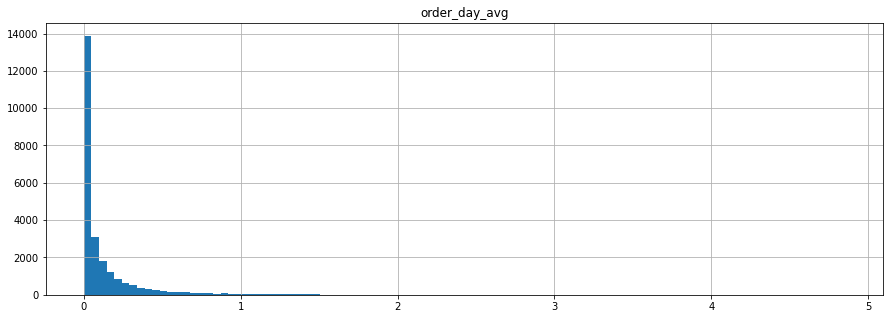

In [405]:
import matplotlib.pyplot as plt
def num_tr(filed,n):
    fig=plt.figure(figsize=(15,5))
    jg_sg_df3[filed].hist(bins=n) 
    plt.title('%s'%filed) 
    plt.show()
num_tr('order_day_avg',100)

<Figure size 864x432 with 0 Axes>

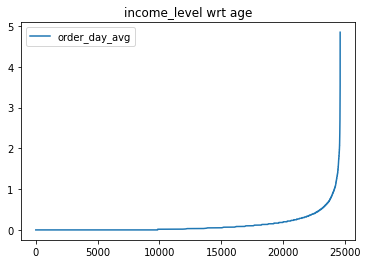

In [414]:
fig=plt.figure(figsize=(12,6))
tmp_df2=jg_sg_df3[['order_day_avg']].sort_values(by='order_day_avg').reset_index(drop=True)
tmp_df2.plot(kind='line')
plt.title('income_level wrt age') 
plt.show()

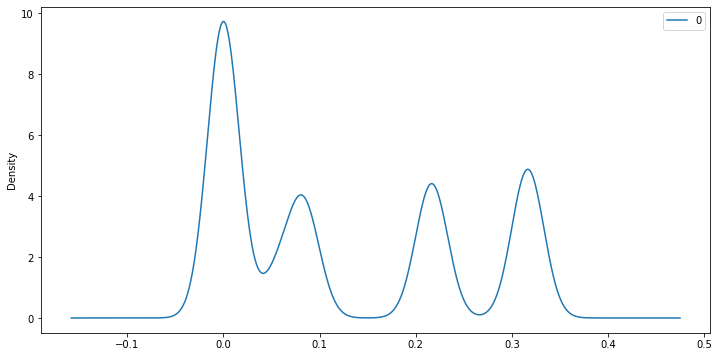

In [416]:
fig=plt.figure(figsize=(12,6))
jg_sg_df3.order_day_avg[jg_sg_df3.age_transformed].plot(kind='kde')
# jg_sg_df3.age_transformed[jg_sg_df3.order_day_avg==1].plot(kind='kde')
plt.legend(('0','1'))
plt.show()


In [418]:
s=pd.Series(jiguang_df.isnull().sum())
s

mobile                                       0
查询结果                                         0
CPL_HHM_CHILD_HC                          8746
CPL_INDM_GEND_S                           2250
CPL_INDM_MARRC2                           2267
CPL_INDM_NATI                             4154
CPL_INDM_AGE_C5                           2748
CPL_HHM_CHILD_CHLI                        8746
CID_MODEL                                 1039
CPL_DVM_BRAD                              1884
CPL_DVM_HF                                 711
CPL_DVM_ISP                               5922
CPL_DVM_OS                                1038
CPL_DVM_PUPR                              1750
CPL_DVM_RESO                              1285
CPL_DVM_SCSIZE                            1299
CPL_DVM_TIME                              1811
CPL_DVM_TYPE                              1689
CPL_INDM_VEIC_VEID                       22171
FIM_FISM_CONL_CIR                        10895
FIM_FISM_INCL                            11788
GBM_BHM_PURB_

In [428]:
# loc[train_df['income_level']==-50000,'income_level']=0
# temp['pref1'].value_counts()
temp['pref1']

0    9851
1     462
Name: pref1, dtype: int64

In [438]:
temp.loc[temp['pref1']==999,'pref1']=0

In [439]:
temp['pref1'].value_counts()

0    9851
1     462
Name: pref1, dtype: int64

In [431]:
temp['pref1'].map(lambda x:111 if x==999 else 1)

5        111
6        111
7        111
8        111
13       111
14       111
15       111
18       111
19       111
24       111
26       111
28       111
29         1
30       111
35       111
40       111
41       111
43       111
45       111
46       111
48       111
49       111
52       111
55       111
56       111
57       111
65       111
66       111
67       111
71       111
73       111
76       111
79       111
80       111
81       111
82       111
83       111
84       111
85       111
87       111
92       111
93       111
94       111
102      111
105      111
107      111
109      111
112      111
115      111
117      111
        ... 
24674    111
24679      1
24681    111
24682      1
24684    111
24685    111
24686    111
24688    111
24689      1
24690    111
24695    111
24696    111
24697    111
24702    111
24703    111
24705    111
24707    111
24709    111
24711    111
24712      1
24714    111
24715    111
24717    111
24718    111
24722    111
24723    111

In [437]:
temp['pref1'].value_counts()

999    9851
1       462
Name: pref1, dtype: int64

In [441]:
a=temp['pref1'].sum()*100.0/temp['pref1'].count()

In [450]:
print('train_df (1,0): ({},{})'.format(round(a,2),round(100-a,2)))

train_df (1,0): (4.48,95.52)


In [521]:
for col in col_feat[:11]:
    print(jg_sg_df3[col].value_counts())

3    15555
5     4303
6     2618
7     1414
4      685
1       31
2        4
Name: sys_ver_transformed, dtype: int64
1    7884
2    6203
3    5715
5    2954
6    1815
4      39
Name: brand_transformed, dtype: int64
3    5016
4    4533
7    4103
2    3793
5    3506
6    2392
1    1267
Name: age_transformed, dtype: int64
2    15595
1     9015
Name: gender, dtype: int64
4    15455
1     5436
2     2837
3      882
Name: SOM_OCM_CAREER_transformed, dtype: int64
2    12787
3     5328
1     4260
0     2235
Name: CPL_INDM_EDU_LEVEL_transformed, dtype: int64
1    19836
2     2522
0     2252
Name: CPL_INDM_MARRC2_transformed, dtype: int64
0    11701
2     8487
1     3416
3     1006
Name: FIM_FISM_INCL_transformed, dtype: int64
0    10815
1     7203
3     4537
2     2055
Name: FIM_FISM_CONL_CIR_transformed, dtype: int64
0    16301
1     8309
Name: N, dtype: int64
0    14871
1     9739
Name: big_offs, dtype: int64


In [522]:
jg_sg_df3[jg_sg_df3.brand_transformed==4]

,mobile,查询结果,CPL_HHM_CHILD_HC,CPL_INDM_GEND_S,CPL_INDM_MARRC2,CPL_INDM_NATI,CPL_INDM_AGE_C5,CPL_HHM_CHILD_CHLI,CID_MODEL,CPL_DVM_BRAD,CPL_DVM_HF,CPL_DVM_ISP,CPL_DVM_OS,CPL_DVM_PUPR,CPL_DVM_RESO,CPL_DVM_SCSIZE,CPL_DVM_TIME,CPL_DVM_TYPE,CPL_INDM_VEIC_VEID,FIM_FISM_CONL_CIR,FIM_FISM_INCL,GBM_BHM_PURB_CONP,GBM_BHM_PURB_PREF,SOM_OCM_CAREER,GBM_HBM_S,GBM_BHM_APPP_APPR_S,GBM_BHM_PURB_PURW,GBM_BHM_PURB_SUPR,GBM_BHM_REAB_REAP,APP_HOBY_BUS,APP_HOBY_TICKET,APP_HOBY_TRAIN,APP_HOBY_FLIGHT,APP_HOBY_TAXI,APP_HOBY_SPECIAL_DRIVE,APP_HOBY_HIGH_BUS,APP_HOBY_OTHER_DRIVE,APP_HOBY_RENT_CAR,APP_HOBY_YOUNG_HOTEL,APP_HOBY_HOME_HOTEL,APP_HOBY_CONVERT_HOTEL,APP_HOBY_BANK_UNIN,APP_HOBY_THIRD_PAY,APP_HOBY_INTERNET_BANK,APP_HOBY_FOREIGN_BANK,APP_HOBY_MIDDLE_BANK,APP_HOBY_CREDIT_CARD,APP_HOBY_CITY_BANK,APP_HOBY_STATE_BANK,APP_HOBY_FUTURES,...,掌上超市,户外运动,分期购,批发,全球导购,美妆导购,零食专卖,全球美食,奢侈品,二手车,情趣专卖,生鲜专卖,美甲,服饰专卖,免税店,二手闲置,动漫周边,母婴玩具,购物导航,包包配饰,海淘,二手手机,汽车专卖,返现,化妆品专卖,比价,手工艺品,拍卖,返现返利,二手车交易,内衣专卖,信用消费,社交电商,电动车,折扣优惠,儿童用品,收藏品,网上超市,虚拟商品,数码专卖,big_offs,生鲜配送,情趣用品,零售百货,图书专卖,二次元专卖,团购特卖,捕鱼,pref,pref1
274,15988361763,查询标签成功-有标签,None,M,已婚,中国,2,None,Y13IL,VIVO,cpu数:四核;cpu型号:联发科 MT6735M;cpu主频:1.0GHZ;ram:未知;...,中国移动,Android,550,854*480,4.5英寸,2015年06月,手机,None,None,None,None,"大众,1.0",企业人员,听音乐&2、工作一族&1、爱美妆&1、看视频&2、社交达人&1、精打细算&4、购物狂&1,壁纸锁屏&1、阅读器&1、便签记事&1、麻将棋牌&2、聊天交友&3、电量流量&1、管家市场&...,None,其它、聊天交友、看电影、听音乐、购物、地图查询、休闲,搜索查询,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
759,15282485976,查询标签成功-有标签,有,F,已婚,中国,1,未知,Y7S,VIVO,cpu数:八核;cpu型号:联发科Helio P65(MT6768);cpu主频:2.0GH...,中国移动,Android,1598,2340×1080,6.38英寸,2019年07月17日,手机,None,None,None,None,"大众,0.991&创意,0.009",白领,听音乐&4、工作一族&5、潮范儿&1、爱美妆&1、益智娱乐&3、看视频&9、社交达人&1、精...,拍照P图&8、办公软件&5、综合商城&3、便签记事&1、wifi网络&1、其他阅读&2、在线...,"网络商城,1.0",其它、看电影、学习辅导、购物、聊天交友、听音乐、玩游戏、转账支付、考试资料、地图查询,孕育知识、搜索查询、查考试资料,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1
1048,15508196067,查询标签成功-有标签,有,M,已婚,中国,1,未知,Y85,VIVO,cpu数:八核;cpu型号:高通 骁龙450;cpu主频:1.8GHZ;ram:未知;手机尺...,中国移动,Android,1098,2280*1080,6.26英寸,2018年3月28日,手机,None,None,None,N,"大众,1.0",None,工作一族&1、游戏狂&1、潮范儿&1、益智娱乐&1、看视频&3、精打细算&4、购物狂&2,阅读器&1、综合新闻&2、便签记事&1、音乐电台&1、角色扮演&1、管家市场&4、网络电话&...,"网络商城,0.65&团购,0.35",其它、购物、看电影、看新闻、玩游戏、养车修车、网络电话,搜索查询,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,股份制银行&0.4775,None,None,None,None,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1
1634,18188362825,查询标签成功-有标签,有,F,已婚,中国,1,婴幼儿,RENO2,OPPO,cpu数:八核;cpu型号:高通 骁龙730G;cpu主频:2.2GHZ;ram:未知;手机...,中国电信,Android,2499,2400*1080,6.5英寸,2019年09月12日,手机,None,中,None,N、图书专卖、品牌折扣,"大众,1.0",白领,听音乐&6、工作一族&3、看视频&6、社交达人&2、精打细算&5、购物狂&5,计算器&1、音乐电台&7、综合商城&3、便签记事&1、wifi网络&1、管家市场&3、在线教...,"网络商城,0.75&购物分享,0.25",其它、看电影、聊天交友、听音乐、学习辅导、购物、玩游戏、地图查询、转账支付、团吃喝,育儿宝典,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,-1
1653,18481577564,查询标签成功-有标签,None,M,已婚,中国,2,None,NOTE,小米,cpu数:四核;cpu型号:高通 骁龙Snapdragon MSM8916;cpu主频:1....,中国移动,Android,799,1280*720,5.5英寸,2015年03月,手机,None,None,None,数码电脑、零售百货,"大众,1.0",None,听音乐&1、文史阅读&1、看视频&1、社交达人&1、精打细算&2、购物狂&2,计算器&1、便签记事&1、其他阅读&1、日历闹钟天气&2、wifi网络&1、聊天交友&2、管...,"网络商城,1.0",其它、读书、聊天交友、购物、考试资料、听音乐、看电影,健身攻略、查考试资料,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-1
1993,15283409607,查询标签成功-有标签,None,None,None,中国,None,None,8X MAX,荣耀,cpu数:八核;cpu型号:未知;cpu主频:未知;ram:未知;手机尺寸:177.57x8...,None,Android,1899,1080*2044,其他英寸,2018年9月,手机,None,None,None,None,None,None,None,

In [523]:
jiguang_df[jiguang_df.mobile==15988361763]

,mobile,查询结果,CPL_HHM_CHILD_HC,CPL_INDM_GEND_S,CPL_INDM_MARRC2,CPL_INDM_NATI,CPL_INDM_AGE_C5,CPL_HHM_CHILD_CHLI,CID_MODEL,CPL_DVM_BRAD,CPL_DVM_HF,CPL_DVM_ISP,CPL_DVM_OS,CPL_DVM_PUPR,CPL_DVM_RESO,CPL_DVM_SCSIZE,CPL_DVM_TIME,CPL_DVM_TYPE,CPL_INDM_VEIC_VEID,FIM_FISM_CONL_CIR,FIM_FISM_INCL,GBM_BHM_PURB_CONP,GBM_BHM_PURB_PREF,SOM_OCM_CAREER,GBM_HBM_S,GBM_BHM_APPP_APPR_S,GBM_BHM_PURB_PURW,GBM_BHM_PURB_SUPR,GBM_BHM_REAB_REAP,APP_HOBY_BUS,APP_HOBY_TICKET,APP_HOBY_TRAIN,APP_HOBY_FLIGHT,APP_HOBY_TAXI,APP_HOBY_SPECIAL_DRIVE,APP_HOBY_HIGH_BUS,APP_HOBY_OTHER_DRIVE,APP_HOBY_RENT_CAR,APP_HOBY_YOUNG_HOTEL,APP_HOBY_HOME_HOTEL,APP_HOBY_CONVERT_HOTEL,APP_HOBY_BANK_UNIN,APP_HOBY_THIRD_PAY,APP_HOBY_INTERNET_BANK,APP_HOBY_FOREIGN_BANK,APP_HOBY_MIDDLE_BANK,APP_HOBY_CREDIT_CARD,APP_HOBY_CITY_BANK,APP_HOBY_STATE_BANK,APP_HOBY_FUTURES,...,CAR_Rental_LocViewDateScore,CAR_Rental_LocViewScore,CAR_Repair_LocViewDateScore,CAR_Repair_LocViewScore,CAR_Sale_LocViewDateScore,CAR_Sale_LocViewScore,CAR_Service_LocViewDateScore,CAR_Service_LocViewScore,ALL_Home_Work_LocDistanceScore,ALL_Trip_LocViewDateScore,ALL_Trip_LocViewScore,EDU_Driving_LocViewDateScore,EDU_Driving_LocViewScore,EDU_Child_LocViewDateScore,EDU_Child_LocViewScore,EDU_Kindergarden_LocViewDateScore,EDU_Kindergarden_LocViewScore,EDU_Primary_LocViewDateScore,EDU_Primary_LocViewScore,EDU_Junior_LocViewDateScore,EDU_Junior_LocViewScore,EDU_Middle_LocViewDateScore,EDU_Middle_LocViewScore,EDU_Senior_LocViewDateScore,EDU_Senior_LocViewScore,EDU_Colleage_LocViewDateScore,EDU_Colleage_LocViewScore,EDU_Abroad_LocViewDateScore,EDU_Abroad_LocViewScore,EDU_Adult_LocViewDateScore,EDU_Adult_LocViewScore,EDU_Art_LocViewDateScore,EDU_Art_LocViewScore,EDU_Body_Building_LocViewDateScore,EDU_Body_Building_LocViewScore,EDU_Gourmand_LocViewDateScore,EDU_Gourmand_LocViewScore,EDU_Language_LocViewDateScore,EDU_Language_LocViewScore,EDU_Officeholder_LocViewDateScore,EDU_Officeholder_LocViewScore,EDU_Postgraduate_LocViewDateScore,EDU_Postgraduate_LocViewScore,HOUSE_Newhouse_LocViewDateScore,HOUSE_Newhouse_LocViewScore,TRAVEL_Travel_Agency_LocViewDateScore,TRAVEL_Travel_Agency_LocViewScore,TRAVEL_Travel_LocViewDateScore,TRAVEL_Travel_LocViewScore,query_result
346,15988361763,查询标签成功-有标签,NaN,M,已婚,中国,2.0,NaN,Y13IL,VIVO,cpu数:四核;cpu型号:联发科 MT6735M;cpu主频:1.0GHZ;ram:未知;...,中国移动,Android,550.0,854*480,4.5英寸,2015年06月,手机,NaN,NaN,NaN,NaN,"大众,1.0",企业人员,听音乐&2、工作一族&1、爱美妆&1、看视频&2、社交达人&1、精打细算&4、购物狂&1,壁纸锁屏&1、阅读器&1、便签记事&1、麻将棋牌&2、聊天交友&3、电量流量&1、管家市场&...,NaN,其它、聊天交友、看电影、听音乐、购物、地图查询、休闲,搜索查询,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [527]:
def get_sys_transform(x):
    try:
        if x.split(' ')[-1]=='11':
            return 1
        elif x.split(' ')[-1]=='10':
            return 2
        elif x.split(' ')[-1]=='9':
            return 3
        elif x.split(' ')[-1]=='8':
            return 4
        else:
            return 5
    except:
        print(x)
        
# merge_df2['sys_ver_transformed']=jg_sg_df3.sys_ver_transform1.apply(get_sys_ver_transform) 

In [526]:
jg_sg_df5=jg_sg_df3
jg_sg_df5['sys_ver_transformed'].value_counts()

3    15555
5     4303
6     2618
7     1414
4      685
1       31
2        4
Name: sys_ver_transformed, dtype: int64

In [528]:
jg_sg_df5['sys_ver_transformed']=jg_sg_df5.sys_ver_transform1.apply(get_sys_transform) 
jg_sg_df5['sys_ver_transformed'].value_counts()

2    15555
3     4303
4     2618
5     1449
1      685
Name: sys_ver_transformed, dtype: int64

In [529]:
jg_sg_df5['brand_transformed'].value_counts()

1    7884
2    6203
3    5715
5    2954
6    1815
4      39
Name: brand_transformed, dtype: int64

In [530]:
def get_brand_transform(x):
    if x=='HUAWEI':
        return 1
    elif x=='OPPO':
        return 2
    elif x=='vivo':
        return 3
    elif x=='HONOR':
        return 4
    else:
        return 5

jg_sg_df5['brand_transformed']=jg_sg_df5.brand.apply(get_brand_transform)
jg_sg_df5['brand_transformed'].value_counts()

1    7884
2    6203
3    5715
4    2954
5    1854
Name: brand_transformed, dtype: int64

In [532]:
temp['pref1'].value_counts()

0    9851
1     462
Name: pref1, dtype: int64

In [536]:
jg_sg_df5[jg_sg_df5.mobile==15988361763]['gender']

274    2
Name: gender, dtype: int64

In [541]:
jg_sg_df5.shape

(24610, 432)

In [540]:
jiguang_df.CPL_INDM_EDU_LEVEL.isnull().sum()

2250

In [538]:
jiguang_df.shape

(24787, 341)

In [557]:
9739/24610

0.3957334416903698

In [555]:
jg_sg_df5[['N','big_offs']]

,N,big_offs
0,1,0
1,0,0
2,0,0
3,1,1
4,0,0
5,1,1
6,0,0
7,0,0
8,0,1
9,0,1


In [ ]:
2    12787
3     5328
1     4260
0     2235
Name: CPL_INDM_EDU_LEVEL_transformed, dtype: int64
        
1    19836
2     2522
0     2252
Name: CPL_INDM_MARRC2_transformed, dtype: int64
        
0    11701
2     8487
1     3416
3     1006
Name: FIM_FISM_INCL_transformed, dtype: int64
        
0    10815
1     7203
3     4537
2     2055
Name: FIM_FISM_CONL_CIR_transformed, dtype: int64
        
0    16301
1     8309
Name: N, dtype: int64
        
0    14871
1     9739
Name: big_offs, dtype: int64

In [559]:
jg_sg_df3[jg_sg_df3.pref1 !=-1]

,mobile,查询结果,CPL_HHM_CHILD_HC,CPL_INDM_GEND_S,CPL_INDM_MARRC2,CPL_INDM_NATI,CPL_INDM_AGE_C5,CPL_HHM_CHILD_CHLI,CID_MODEL,CPL_DVM_BRAD,CPL_DVM_HF,CPL_DVM_ISP,CPL_DVM_OS,CPL_DVM_PUPR,CPL_DVM_RESO,CPL_DVM_SCSIZE,CPL_DVM_TIME,CPL_DVM_TYPE,CPL_INDM_VEIC_VEID,FIM_FISM_CONL_CIR,FIM_FISM_INCL,GBM_BHM_PURB_CONP,GBM_BHM_PURB_PREF,SOM_OCM_CAREER,GBM_HBM_S,GBM_BHM_APPP_APPR_S,GBM_BHM_PURB_PURW,GBM_BHM_PURB_SUPR,GBM_BHM_REAB_REAP,APP_HOBY_BUS,APP_HOBY_TICKET,APP_HOBY_TRAIN,APP_HOBY_FLIGHT,APP_HOBY_TAXI,APP_HOBY_SPECIAL_DRIVE,APP_HOBY_HIGH_BUS,APP_HOBY_OTHER_DRIVE,APP_HOBY_RENT_CAR,APP_HOBY_YOUNG_HOTEL,APP_HOBY_HOME_HOTEL,APP_HOBY_CONVERT_HOTEL,APP_HOBY_BANK_UNIN,APP_HOBY_THIRD_PAY,APP_HOBY_INTERNET_BANK,APP_HOBY_FOREIGN_BANK,APP_HOBY_MIDDLE_BANK,APP_HOBY_CREDIT_CARD,APP_HOBY_CITY_BANK,APP_HOBY_STATE_BANK,APP_HOBY_FUTURES,...,掌上超市,户外运动,分期购,批发,全球导购,美妆导购,零食专卖,全球美食,奢侈品,二手车,情趣专卖,生鲜专卖,美甲,服饰专卖,免税店,二手闲置,动漫周边,母婴玩具,购物导航,包包配饰,海淘,二手手机,汽车专卖,返现,化妆品专卖,比价,手工艺品,拍卖,返现返利,二手车交易,内衣专卖,信用消费,社交电商,电动车,折扣优惠,儿童用品,收藏品,网上超市,虚拟商品,数码专卖,big_offs,生鲜配送,情趣用品,零售百货,图书专卖,二次元专卖,团购特卖,捕鱼,pref,pref1
5,18583886366,查询标签成功-有标签,有,M,已婚,中国,3,青少年,6,一加,cpu数:八核;cpu型号:高通 骁龙845;cpu主频:2.8GHZ;ram:未知;手机尺...,中国联通,Android,2258,2280*1080,6.28英寸,2018年05月,手机,None,None,None,二手闲置、N、品牌折扣,"大众,1.0",None,听音乐&1、潮范儿&2、爱美食&1、益智娱乐&1、看视频&3、精打细算&1、购物狂&4、驴友&1,家装家具&2、便签记事&1、综合新闻&1、综合商城&4、聊天交友&2、城市出行&2、动作竞速...,"网络商城,0.8&团购,0.2",学习辅导、其它、聊天交友、购物、看电影、玩游戏、转账支付、休闲、看新闻、交规查询,论坛微博、旅游攻略、交规学习、查考试资料、综合新闻,公交&0.4619,None,火车高铁&0.4556,None,打车&0.0001,None,None,None,None,None,None,None,None,None,None,None,None,None,None,国有银行&0.4505,None,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
6,18583512631,查询标签成功-有标签,None,M,已婚,中国,1,None,Y75,VIVO,cpu数:八核;cpu型号:联发科 MT6763;cpu主频:2.0GHZ;ram:未知;手...,中国移动,Android,1098,1440*720,5.7英寸,2017年12月,手机,None,中,低,零售百货,"大众,1.0",公务人员,听音乐&1、爱美食&1、看视频&3、社交达人&1、精打细算&1、驴友&1,阅读器&1、短视频&3、便签记事&1、综合新闻&1、在线教育&1、音乐电台&4、生活小工具&...,"团购,1.0",其它、看电影、聊天交友、团吃喝、看新闻、学习辅导、听音乐、旅游攻略、地图查询,旅游攻略、综合新闻、搜索查询,None,None,None,None,打车&0.0001,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7,18728967538,查询标签成功-有标签,None,F,已婚,中国,2,None,NOVA 4E,None,cpu数:八核;cpu型号:海思 麒麟 710;cpu主频:4×CORTEX-A73 2.2...,None,Android,1999,2312*1080,6.15英寸,2019年03月,手机,None,None,None,数码电脑,None,None,None,None,None,None,孕育知识,None,None,None,None,None,None,None,None,None,None,None,None,银联二维码&0.4107,None,None,None,None,None,None,None,None,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,18280686507,查询标签成功-有标签,None,M,已婚,中国,2,None,GALAXY GRAND 2,三星,cpu数:四核;cpu型号:高通 骁龙Snapdragon MSM8226;cpu主频:1....,中国移动,Android,699,1280*720,5.25英寸,2013年11月,手机,None,中,低,品牌折扣,"大众,1.0",None,听音乐&2、工作一族&1、益智娱乐&2、看视频&1、精打细算&1、购物狂&1,音乐电台&2、搜索浏览器&2、视频播放&1、休闲益智&1、导航地图&2、综合商城&1、其他工...,"网络商城,1.0",其它、地图查询、听音乐、玩游戏、购物、看电影,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
13,18783400680,查询标签成功-有标签,None,F,已婚,中国,2,None,M6 PLUS,金立,cpu数:八核;cpu型号:联发科 MT6755;cpu主频:2.0GHZ;ram:未知;手...,中国移动,Android,2399,1920*1080,6英寸,2016年08月,手机,None,None,None,零售百货、团购特卖、返利返现、二手闲置、全球导购、品牌折扣,"大众,1.0",企业人员,爱美食&1、购物狂&1,阅读器&1、移动K歌&1、计算器&1、生活小工具&3、便签记事&1、其他工具&4、聊天交友&...,"团购,1.0",其它、聊天交友、购物、团吃喝,查药方、查食谱、搜索查询,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0
14,15364162485,查询标签成功-有标签,None,M,已婚,中国,2,None,IQOO NEO 855,VIVO,cpu数:未知;cpu型号:未知;cpu主频:未知;ram:未知;手机尺寸:159.53x7...,None,Android,1998,1080*2141,6.38英寸,2019年10月,手机,None,None,None,二手闲置、、农产品,None,司机,None,None,None,None,搜索查询、养车宝典、育儿宝典、旅游攻略、读邮件、交规学习,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

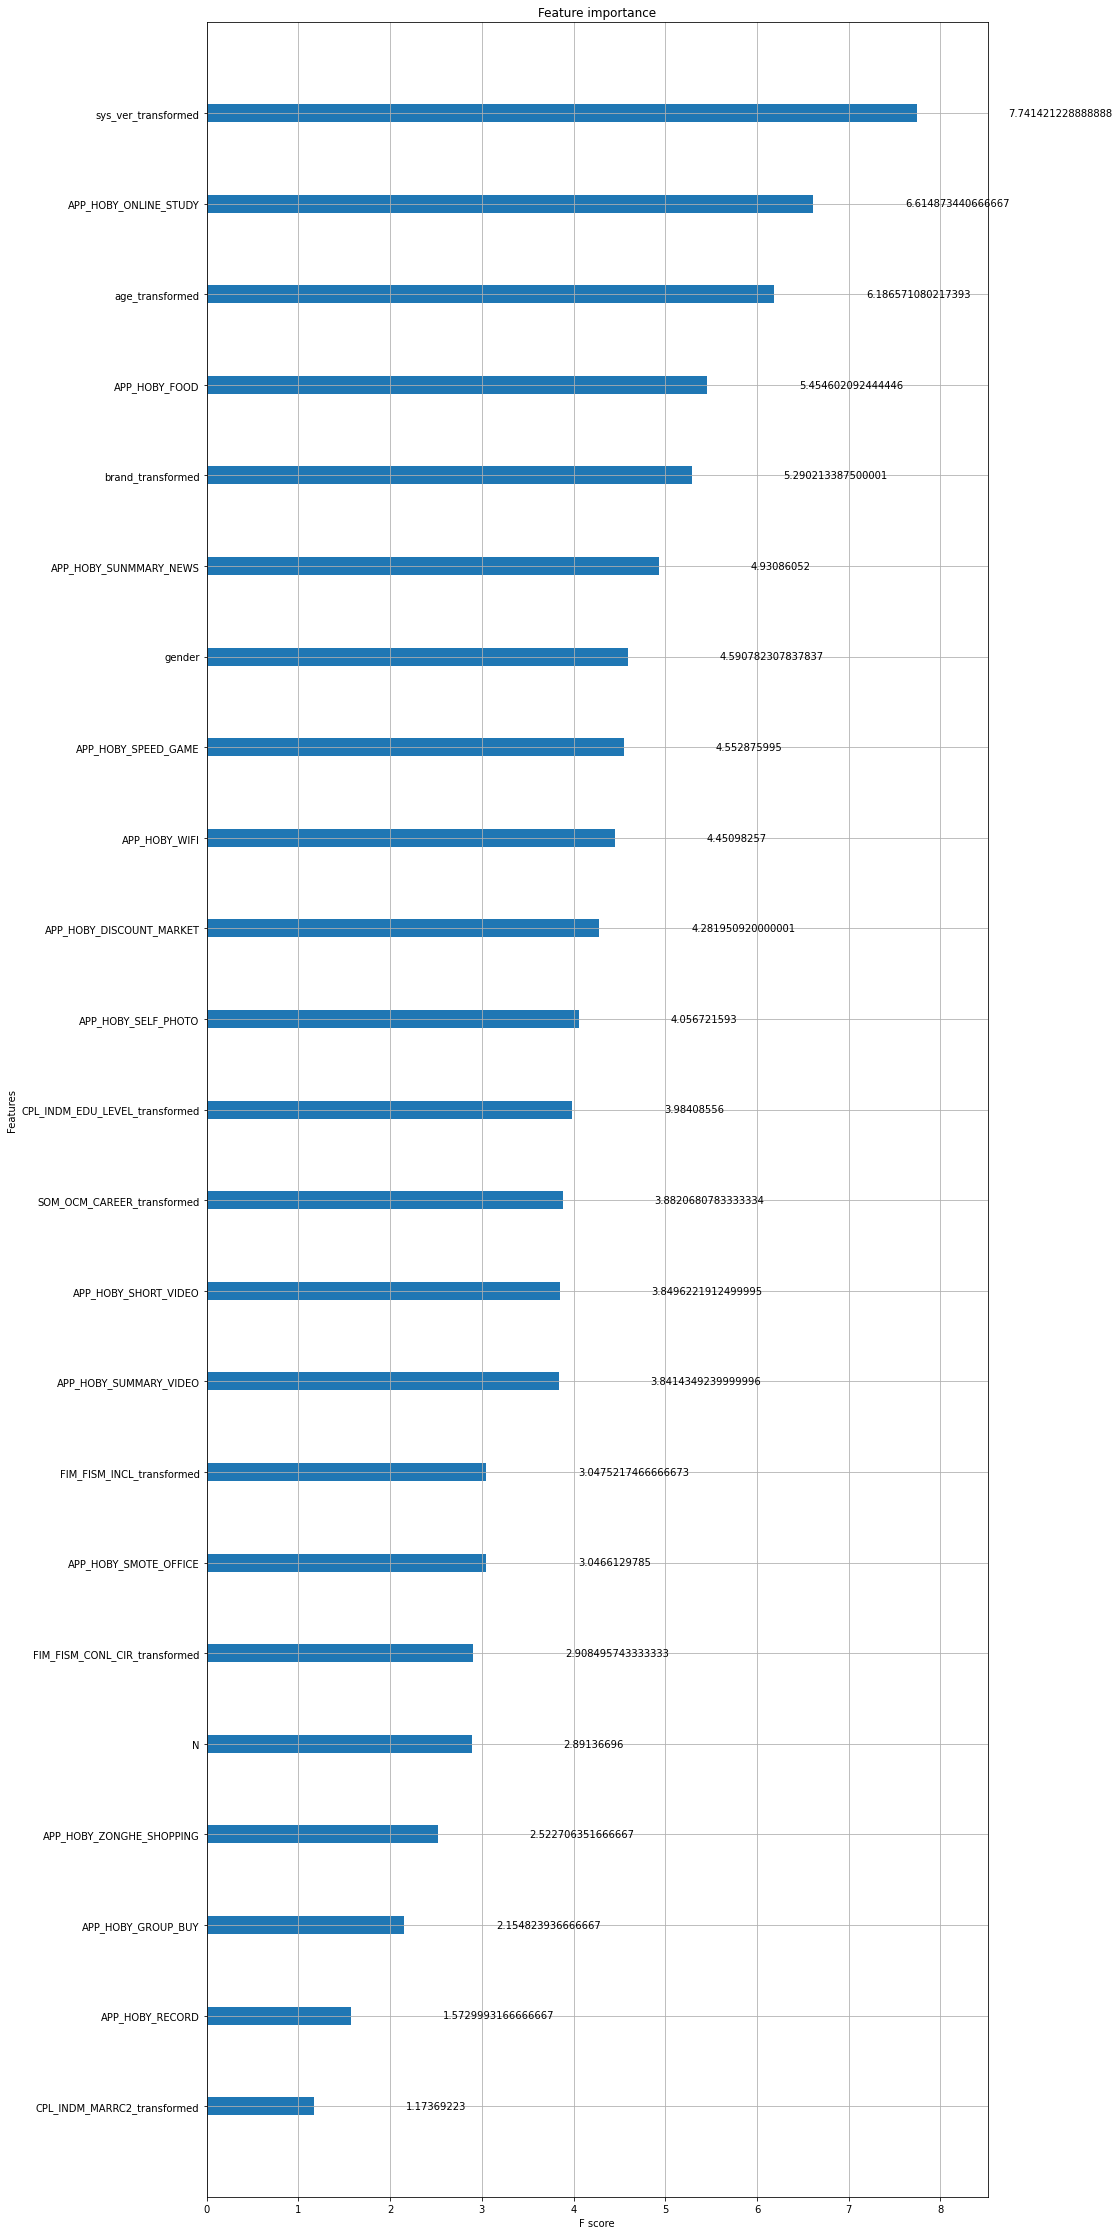

In [570]:
plt.rcParams["figure.figsize"] = (14, 40)
plot_importance(model,importance_type='gain')

In [581]:
for col in hobby_list:
#     print(col)
    print(jg_sg_df3[jg_sg_df3[col]>0].shape[0]/jg_sg_df3.shape[0])

0.6919544900446972
0.7509955302722471
0.7569280780170662
0.4888256806176351
0.3906135717188135
0.6046728971962617
0.45209264526615195
0.5343762698090208
0.7830963023161317
0.2947582283624543
0.672003250711093
0.3133685493701747
0.33457943925233646
0.7251117431938237


In [580]:
jg_sg_df3[jg_sg_df3['APP_HOBY_SHORT_VIDEO']>0].shape[0]/jg_sg_df3.shape[0]

0.6919544900446972

In [579]:
jg_sg_df3.shape

(24610, 432)

In [604]:
jg_sg_df5[jg_sg_df5.pref1==1]

,mobile,查询结果,CPL_HHM_CHILD_HC,CPL_INDM_GEND_S,CPL_INDM_MARRC2,CPL_INDM_NATI,CPL_INDM_AGE_C5,CPL_HHM_CHILD_CHLI,CID_MODEL,CPL_DVM_BRAD,CPL_DVM_HF,CPL_DVM_ISP,CPL_DVM_OS,CPL_DVM_PUPR,CPL_DVM_RESO,CPL_DVM_SCSIZE,CPL_DVM_TIME,CPL_DVM_TYPE,CPL_INDM_VEIC_VEID,FIM_FISM_CONL_CIR,FIM_FISM_INCL,GBM_BHM_PURB_CONP,GBM_BHM_PURB_PREF,SOM_OCM_CAREER,GBM_HBM_S,GBM_BHM_APPP_APPR_S,GBM_BHM_PURB_PURW,GBM_BHM_PURB_SUPR,GBM_BHM_REAB_REAP,APP_HOBY_BUS,APP_HOBY_TICKET,APP_HOBY_TRAIN,APP_HOBY_FLIGHT,APP_HOBY_TAXI,APP_HOBY_SPECIAL_DRIVE,APP_HOBY_HIGH_BUS,APP_HOBY_OTHER_DRIVE,APP_HOBY_RENT_CAR,APP_HOBY_YOUNG_HOTEL,APP_HOBY_HOME_HOTEL,APP_HOBY_CONVERT_HOTEL,APP_HOBY_BANK_UNIN,APP_HOBY_THIRD_PAY,APP_HOBY_INTERNET_BANK,APP_HOBY_FOREIGN_BANK,APP_HOBY_MIDDLE_BANK,APP_HOBY_CREDIT_CARD,APP_HOBY_CITY_BANK,APP_HOBY_STATE_BANK,APP_HOBY_FUTURES,...,掌上超市,户外运动,分期购,批发,全球导购,美妆导购,零食专卖,全球美食,奢侈品,二手车,情趣专卖,生鲜专卖,美甲,服饰专卖,免税店,二手闲置,动漫周边,母婴玩具,购物导航,包包配饰,海淘,二手手机,汽车专卖,返现,化妆品专卖,比价,手工艺品,拍卖,返现返利,二手车交易,内衣专卖,信用消费,社交电商,电动车,折扣优惠,儿童用品,收藏品,网上超市,虚拟商品,数码专卖,big_offs,生鲜配送,情趣用品,零售百货,图书专卖,二次元专卖,团购特卖,捕鱼,pref,pref1
29,17828552550,查询标签成功-有标签,None,M,已婚,中国,1,None,X6 PLUS,VIVO,cpu数:八核;cpu型号:联发科 MT6752;cpu主频:1.7GHZ;ram:未知;手...,中国移动,Android,2359,1920*1080,5.7英寸,2015年12月,手机,None,None,None,N、,"大众,1.0",白领,听音乐&2、社交达人&2、精打细算&2、购物狂&3、金融理财&1,其他工具&7、阅读器&1、便签记事&1、综合商城&2、管家市场&4、聊天交友&3、邮箱&2、...,"团购,0.5&网络商城,0.5",其它、转账支付、聊天交友、购物、听音乐、收发邮件、投资,读邮件、搜索查询,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,信用卡&0.0001,None,None,None,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
37,13795620526,查询标签成功-有标签,None,None,None,中国,None,None,R9 PLUS,OPPO,cpu数:八核;cpu型号:高通 骁龙Snapdragon MSM8976;cpu主频:1....,None,Android,3599,1920*1080,6英寸,2016年04月,手机,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
47,18215530968,查询标签成功-有标签,有,F,已婚,中国,2,未知,P30,华为,cpu数:八核;cpu型号:海思 麒麟 980;cpu主频:2*CORTEX-A76 BAS...,中国电信,Android,3188,2340*1080,6.1英寸,2019年04月,手机,None,高,None,数码电脑、品牌折扣,"大众,1.0",公务人员,健康养生&1、听音乐&1、工作一族&3、文史阅读&1、爱美食&2、益智娱乐&1、看视频&5、...,视频播放&9、小说阅读&1、便签记事&1、综合新闻&1、综合商城&4、wifi网络&1、支付...,"网络商城,0.67&团购,0.33",其它、聊天交友、购物、看电影、休闲、健身攻略、转账支付、学习辅导、团吃喝、考试资料,外文阅读、旅游攻略、查考试资料、读邮件、综合新闻、健身攻略,None,None,None,None,None,None,None,None,None,None,民宿&0.1175,None,银联二维码&0.1329,None,None,None,None,None,None,None,None,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1
60,13923619433,查询标签成功-有标签,无,M,已婚,中国,2,未知,X23,VIVO,cpu数:八核;cpu型号:高通 骁龙670AIE;cpu主频:2.0GHZ;ram:未知;...,中国电信,Android,1999,2340*1080,6.41英寸,2018年09月06日,手机,None,中,低,None,"大众,1.0",企业人员,听音乐&1、工作一族&1、游戏狂&1、看视频&1、精打细算&2、购物狂&1,阅读器&1、便签记事&1、生鲜电商&1、wifi网络&1、订票酒店&1、聊天交友&1、生活小...,None,其它、聊天交友、听音乐、订票酒店、看电影,搜索查询,None,None,火车高铁&0.1527,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
69,15828106140,查询标签成功-有标签,None,None,None,中国,None,None,Y85,VIVO,cpu数:八核;cpu型号:高通 骁龙450;cpu主频:1.8GHZ;ram:未知;手机尺...,None,Android,1098,2280*1080,6.26英寸,2018年3月28日,手机,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
106,15182630797,查询标签成功-有标签,无,F,未婚,中国,1,未知,Y97,VIVO,cpu数:八核;cpu型号:联发科 Helio P60（MT6771）;cpu主频:2.0G...,中国移动,Android,2098,2280*1080,6.3英寸,2018年09月11日,手机,None,中,低,零售百货、返利返现、二手车交易、品牌折扣,"大众,1.0",None,听音乐&2、工作一族&1、文史阅读&1、汽车迷&1、爱美食&1、看视频&2、社交达人&1、精...,生活小工具&3、便签记事&1、综合新闻&1、wifi网络&1、管家市场&3、聊天交友&4、导...,"团购,0.33&网络商城,0.67",学习辅导、考试资料、其它、聊天交友、购物、听音乐、看电影、看新闻、转账支付、地图查询,综合新闻、旅游攻略、搜索查询、汽车资讯、读邮件、查考试资料,None,None,None,None,None,None,None,None,None,None,None,